In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import eigs

###### Function for Computing Scaled Laplacian

In [ ]:
def scaled_Laplacian(W):
    '''
    compute \tilde{L}

    Parameters
    ----------
    W: np.ndarray, shape is (N, N), N is the num of vertices

    Returns
    ----------
    scaled_Laplacian: np.ndarray, shape (N, N)

    '''
    ###Checking if the number of rows and columns of an adjacenecy matrix
    ####are same or not
    assert W.shape[0] == W.shape[1]

    ### First sum each row of the adjacency matrix, and we obtain the degress of each vertex in that row
    ### Secondly, a diagonal matrix has been created with degree of each vertex in the diagonal
    #### Finally, 'D' is the sparse matrix containing only degrees of each vertex
    D = np.diag(np.sum(W, axis=1))

    #### 'l' is the unormalized Laplacian Matrix obtained by subtraction
    ### of Adjacenecy Matrix from the Diagonal Matrix
    L = D - W

    #### First of all from the Laplacian Matrix, with the help of 'eigs' function largest value for eigen value and eigne vector
    ##### has been evaluated
    #### Secondly, eigen value has been only kept
    #### Thirdly, eigen value beign a complex number, only real part is kept and saved as lamda_max
    lambda_max = eigs(L, k=1, which='LR')[0].real

    #### Finally Scaled Laplacian Matrix value is Obtained
    return (2 * L) / lambda_max - np.identity(W.shape[0])


##### Function for Computing Chebyshev Polynomials

In [ ]:
def cheb_polynomial(L_tilde, K):
    '''
    compute a list of chebyshev polynomials from T_0 to T_{K-1}

    Parameters
    ----------
    L_tilde: scaled Laplacian, np.ndarray, shape (N, N)

    K: the maximum order of chebyshev polynomials

    Returns
    ----------
    cheb_polynomials: list(np.ndarray), length: K, from T_0 to T_{K-1}

    '''
    ### The value of N is set to number of rows of a Laplacian Matric
    N = L_tilde.shape[0]

    ### cheb_polynimials conatins the zeroth order Chebyshev Polynomial T(0) = np.identity(N)
    ### and the first order Chebyshev Polynomial T(1) = L_tilde.copy()
    cheb_polynomials = [np.identity(N), L_tilde.copy()]

    ### The loop computes the next higher order of Chebyshev Polynomials form order 2 to order k
    ### The next order recurrence Chebysehev Polynomial is given by Tk(x) =2xTk-1(x)-Tk-2(x)
    ## Since the loop starts from order 2, I am experimenting with values K = 3, 4, 5
    for i in range(2, K):
        cheb_polynomials.append(2 * L_tilde * cheb_polynomials[i - 1] - cheb_polynomials[i - 2])

    return cheb_polynomials

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

###### Chebyshev's Convolution Layer

In [ ]:
class cheb_conv(nn.Module):
    '''
    K-order chebyshev graph convolution
    '''

    def __init__(self, K, cheb_polynomials, in_channels, out_channels):
        '''
        :param K: int
        :param in_channles: int, num of channels in the input sequence
        :param out_channels: int, num of channels in the output sequence
        '''
        super(cheb_conv, self).__init__()
        self.K = K
        self.cheb_polynomials = cheb_polynomials
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.DEVICE = cheb_polynomials[0].device
        self.Theta = nn.ParameterList([nn.Parameter(torch.FloatTensor(in_channels, out_channels).to(self.DEVICE)) for _ in range(K)])

    def forward(self, x):
        '''
        Chebyshev graph convolution operation
        :param x: (batch_size, N, F_in, T)
        :return: (batch_size, N, F_out, T)
        '''

        batch_size, num_of_vertices, in_channels, num_of_timesteps = x.shape

        outputs = []

        for time_step in range(num_of_timesteps):

            graph_signal = x[:, :, :, time_step]  # (b, N, F_in)

            output = torch.zeros(batch_size, num_of_vertices, self.out_channels).to(self.DEVICE)  # (b, N, F_out)

            for k in range(self.K):

                T_k = self.cheb_polynomials[k]  # (N,N)

                theta_k = self.Theta[k]  # (in_channel, out_channel)

                rhs = graph_signal.permute(0, 2, 1).matmul(T_k).permute(0, 2, 1)

                output = output + rhs.matmul(theta_k)

            outputs.append(output.unsqueeze(-1))

        return F.relu(torch.cat(outputs, dim=-1))


###### Describing a Singular MSTGCN Block

In [ ]:
class MSTGCN_block(nn.Module):

    def __init__(self, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials):
        super(MSTGCN_block, self).__init__()
        self.cheb_conv = cheb_conv(K, cheb_polynomials, in_channels, nb_chev_filter)
        self.time_conv = nn.Conv2d(nb_chev_filter, nb_time_filter, kernel_size=(1, 3), stride=(1, time_strides), padding=(0, 1))
        self.residual_conv = nn.Conv2d(in_channels, nb_time_filter, kernel_size=(1, 1), stride=(1, time_strides))
        self.ln = nn.LayerNorm(nb_time_filter)

    def forward(self, x):
        '''
        :param x: (batch_size, N, F_in, T)
        :return: (batch_size, N, nb_time_filter, T)
        '''
        # cheb gcn
        spatial_gcn = self.cheb_conv(x)  # (b,N,F,T)

        # convolution along the time axis
        time_conv_output = self.time_conv(spatial_gcn.permute(0, 2, 1, 3))  # (b,F,N,T)

        # residual shortcut
        x_residual = self.residual_conv(x.permute(0, 2, 1, 3))  # (b,F,N,T)

        x_residual = self.ln(F.relu(x_residual + time_conv_output).permute(0, 3, 2, 1)).permute(0, 2, 3, 1)  # (b,N,F,T)

        return x_residual

###### Describing a series of MSTGCN Blocks inside the submodule Class

In [ ]:
class MSTGCN_submodule(nn.Module):

    def __init__(self, DEVICE, nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_for_predict, len_input):
        '''
        :param nb_block:
        :param in_channels:
        :param K:
        :param nb_chev_filter:
        :param nb_time_filter:
        :param time_strides:
        :param cheb_polynomials:
        :param nb_predict_step:
        '''

        super(MSTGCN_submodule, self).__init__()

        self.BlockList = nn.ModuleList([MSTGCN_block(in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials)])

        self.BlockList.extend([MSTGCN_block(nb_time_filter, K, nb_chev_filter, nb_time_filter, 1, cheb_polynomials) for _ in range(nb_block-1)])

        self.final_conv = nn.Conv2d(int(len_input/time_strides), num_for_predict, kernel_size=(1, nb_time_filter))

        self.DEVICE = DEVICE

        self.to(DEVICE)

    def forward(self, x):
        '''
        :param x: (B, N_nodes, F_in, T_in)
        :return: (B, N_nodes, T_out)
        '''
        for block in self.BlockList:
            x = block(x)

        output = self.final_conv(x.permute(0, 3, 1, 2))[:, :, :, -1].permute(0, 2, 1)

        return output


###### Making Model Function

In [ ]:
def make_model(DEVICE, nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, adj_mx, num_for_predict, len_input):
    '''

    :param DEVICE:
    :param nb_block:
    :param in_channels:
    :param K:
    :param nb_chev_filter:
    :param nb_time_filter:
    :param time_strides:
    :param cheb_polynomials:
    :param nb_predict_step:
    :param len_input
    :return:
    '''
    L_tilde = scaled_Laplacian(adj_mx)
    cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
    model = MSTGCN_submodule(DEVICE, nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_for_predict, len_input)

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [ ]:
import torch

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 679.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse.linalg import eigs


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='.', flush_secs=5)

import math
from typing import Optional, List, Union

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
#from torch_scatter import scatter_add

CUDA: True cuda:0


###### Loading the Dataset and dividing the Dataset into Training, Testing and Validation

In [ ]:
def load_graphdata_channel1(batch_size,shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    #file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    #filename = os.path.join('../input/processing-traffic-data-for-deep-learning-projects/', file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) +'_astcgn'
    #print('load file:', filename)

    file_data = np.load(r"/content/drive/MyDrive/COMP9491_ASTGCN_Model/MSTGCN_Model_Hourly_07/For_PEMS07/PEMS07_r1_d0_w0_astcgn.npz")
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std

###### Loading the Data and receiving the dimensions of training, testing and validation tensors

In [ ]:
batch_size = 64

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(batch_size)

train: torch.Size([16920, 883, 1, 12]) torch.Size([16920, 883, 12])
val: torch.Size([5640, 883, 1, 12]) torch.Size([5640, 883, 12])
test: torch.Size([5641, 883, 1, 12]) torch.Size([5641, 883, 12])


###### Function To Obtain Adjacenecy Matrix from the Graph Data

In [ ]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    Parameters
    ----------
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    ----------
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:

        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        #------------ Ignore
        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
         #-------------Continue reading
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

In [ ]:
id_filename = None
adj_filename = r'/content/drive/MyDrive/COMP9491_ASTGCN_Model/Dataset_PEMS07/PEMS07.csv'
num_of_vertices = 883
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename)

In [ ]:
def masked_mape_np(y_true, y_pred, null_val=np.nan):
    with np.errstate(divide='ignore', invalid='ignore'):
        if np.isnan(null_val):
            mask = ~np.isnan(y_true)
        else:
            mask = np.not_equal(y_true, null_val)
        mask = mask.astype('float32')
        mask /= np.mean(mask)
        mape = np.abs(np.divide(np.subtract(y_pred, y_true).astype('float32'),
                      y_true))
        mape = np.nan_to_num(mask * mape)
        return np.mean(mape)

In [ ]:
def masked_mse(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    # print(mask.sum())
    # print(mask.shape[0]*mask.shape[1]*mask.shape[2])
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = (preds - labels)**2
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

In [ ]:
def masked_rmse(preds, labels, null_val=np.nan):
    return torch.sqrt(masked_mse(preds=preds, labels=labels,
                                 null_val=null_val))

In [ ]:
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        ###creates a mask where values are present are set to True
        #### where missing values are present, are set to False
        mask = ~torch.isnan(labels)
    else:
        ### if there is no missing value, create a mask where values are False
        mask = (labels != null_val)
    mask = mask.float()

    ##normalizing the weight of the mask, by dividing with mean of mask values
    mask /= torch.mean((mask))

    ##Replaces any Missing value in Mask with Zero
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)

    ##Computing the meas value of mean absolute error
    return torch.mean(loss)

In [ ]:
def masked_mae_test(y_true, y_pred, null_val=np.nan):
    with np.errstate(divide='ignore', invalid='ignore'):
        if np.isnan(null_val):
            mask = ~np.isnan(y_true)
        else:
            mask = np.not_equal(y_true, null_val)
        mask = mask.astype('float32')
        mask /= np.mean(mask)
        mae = np.abs(np.subtract(y_pred, y_true).astype('float32'),
                      )
        mae = np.nan_to_num(mask * mae)
        return np.mean(mae)

In [ ]:
def masked_rmse_test(y_true, y_pred, null_val=np.nan):
    with np.errstate(divide='ignore', invalid='ignore'):
        if np.isnan(null_val):
            mask = ~np.isnan(y_true)
        else:
            # null_val=null_val
            mask = np.not_equal(y_true, null_val)
        mask = mask.astype('float32')
        mask /= np.mean(mask)
        mse = ((y_pred- y_true)**2)
        mse = np.nan_to_num(mask * mse)
        return np.sqrt(np.mean(mse))

In [ ]:
masked_flag=0
criterion = nn.L1Loss().to(DEVICE)
criterion_masked = masked_mae
loss_function = 'mse'

metric_method = 'unmask'
missing_value=0.0


if loss_function=='masked_mse':
    criterion_masked = masked_mse         #nn.MSELoss().to(DEVICE)
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)
    ###indicating that standard loss function will be used
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)
    masked_flag= 0

###### Model is made for Neighbors, K = 5

In [ ]:
model_hour_k5 = make_model(DEVICE, 2, 1, 5,
                        64, 64, 1, adj_mx,
                        12, 12, 883)

In [ ]:
print(model_hour_k5)

ASTGCN_submodule(
  (BlockList): ModuleList(
    (0): ASTGCN_block(
      (TAt): Temporal_Attention_layer()
      (SAt): Spatial_Attention_layer()
      (cheb_conv_SAt): cheb_conv_withSAt(
        (Theta): ParameterList(
            (0): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (1): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (2): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (3): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (4): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
        )
      )
      (time_conv): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (residual_conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCN_block(
      (TAt): Temporal_Attention_layer()
      (SAt): Spatial_Attention_layer()
      (cheb_conv_SAt): cheb_conv_withSAt(
    

In [ ]:
model_hour_k4 = make_model(DEVICE, 2, 1, 4,
                        64, 64, 1, adj_mx,
                        12, 12)

In [ ]:
print(model_hour_k4)

MSTGCN_submodule(
  (BlockList): ModuleList(
    (0): MSTGCN_block(
      (cheb_conv): cheb_conv(
        (Theta): ParameterList(
            (0): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (1): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (2): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (3): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
        )
      )
      (time_conv): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (residual_conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): MSTGCN_block(
      (cheb_conv): cheb_conv(
        (Theta): ParameterList(
            (0): Parameter containing: [torch.float32 of size 64x64 (cuda:0)]
            (1): Parameter containing: [torch.float32 of size 64x64 (cuda:0)]
            (2): Parameter containing: [torch.float32 of size 64x64 (cuda:0

###### Defining the Optimizers and Model configurations for K =5

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(model_hour_k5.parameters(), lr=learning_rate)

In [ ]:
print('Net\'s state_dict:')
total_param = 0
for param_tensor in model_hour_k5.state_dict():
    print(param_tensor, '\t', model_hour_k5.state_dict()[param_tensor].size(), '\t', model_hour_k5.state_dict()[param_tensor].device)
    total_param += np.prod(model_hour_k5.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
BlockList.0.TAt.U1 	 torch.Size([883]) 	 cuda:0
BlockList.0.TAt.U2 	 torch.Size([1, 883]) 	 cuda:0
BlockList.0.TAt.U3 	 torch.Size([1]) 	 cuda:0
BlockList.0.TAt.be 	 torch.Size([1, 12, 12]) 	 cuda:0
BlockList.0.TAt.Ve 	 torch.Size([12, 12]) 	 cuda:0
BlockList.0.SAt.W1 	 torch.Size([12]) 	 cuda:0
BlockList.0.SAt.W2 	 torch.Size([1, 12]) 	 cuda:0
BlockList.0.SAt.W3 	 torch.Size([1]) 	 cuda:0
BlockList.0.SAt.bs 	 torch.Size([1, 883, 883]) 	 cuda:0
BlockList.0.SAt.Vs 	 torch.Size([883, 883]) 	 cuda:0
BlockList.0.cheb_conv_SAt.Theta.0 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv_SAt.Theta.1 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv_SAt.Theta.2 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv_SAt.Theta.3 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv_SAt.Theta.4 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.time_conv.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
BlockList.0.time_conv.bias 	 torch.Size([64]) 	 cuda:0
BlockList.0.residual_conv.weight 

###### Defining Optimization and Config for Model, K = 4

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(model_hour_k4.parameters(), lr=learning_rate)

In [ ]:
print('Net\'s state_dict:')
total_param = 0
for param_tensor in model_hour_k4.state_dict():
    print(param_tensor, '\t', model_hour_k4.state_dict()[param_tensor].size(), '\t', model_hour_k4.state_dict()[param_tensor].device)
    total_param += np.prod(model_hour_k4.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
BlockList.0.cheb_conv.Theta.0 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv.Theta.1 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv.Theta.2 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv.Theta.3 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.time_conv.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
BlockList.0.time_conv.bias 	 torch.Size([64]) 	 cuda:0
BlockList.0.residual_conv.weight 	 torch.Size([64, 1, 1, 1]) 	 cuda:0
BlockList.0.residual_conv.bias 	 torch.Size([64]) 	 cuda:0
BlockList.0.ln.weight 	 torch.Size([64]) 	 cuda:0
BlockList.0.ln.bias 	 torch.Size([64]) 	 cuda:0
BlockList.1.cheb_conv.Theta.0 	 torch.Size([64, 64]) 	 cuda:0
BlockList.1.cheb_conv.Theta.1 	 torch.Size([64, 64]) 	 cuda:0
BlockList.1.cheb_conv.Theta.2 	 torch.Size([64, 64]) 	 cuda:0
BlockList.1.cheb_conv.Theta.3 	 torch.Size([64, 64]) 	 cuda:0
BlockList.1.time_conv.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
BlockList.1.time_conv.bias 	 torch.Size([64]) 	 cuda:0
BlockList.1.residua

In [ ]:
from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='.', flush_secs=5)

In [ ]:
def compute_val_loss_mstgcn(net, val_loader, criterion,  masked_flag,missing_value,sw, epoch, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param sw: tensorboardX.SummaryWriter
    :param global_step: int, current global_step
    :param limit: int,
    :return: val_loss
    '''

    net.train(False)  # ensure dropout layers are in evaluation mode

    with torch.no_grad():

        val_loader_length = len(val_loader)  # nb of batch

        tmp = []  # batch loss

        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs)
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)

            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
    return validation_loss


###### Training for Model with neighbors, set K = 5

In [ ]:
global_step_k5 = 0
best_epoch_k5 = 0
best_val_loss_k5 = np.inf
start_time= time()

In [ ]:
validation_loss_list = []
training_loss_list = []
final_train_loss = []

# train model
#masked_flag = 0
for epoch in range(20):

    params_filename = os.path.join('./', 'epoch_%s.params' % epoch)
    masked_flag = 1

    if masked_flag:
        val_loss = compute_val_loss_astgcn(model_hour_k5, val_loader, criterion_masked, masked_flag,missing_value,sw, epoch)
    else:
        val_loss = compute_val_loss_astgcn(model_hour_k5, val_loader, criterion, masked_flag, missing_value, sw, epoch)

    ###appending the validation Loss in the List
    validation_loss_list.append(val_loss)
    if val_loss < best_val_loss_k5:
        best_val_loss_k5 = val_loss
        best_epoch_k5 = epoch
        torch.save(model_hour_k5.state_dict(), params_filename)
        print('save parameters to file: %s' % params_filename)

    model_hour_k5.train()  # ensure dropout layers are in train mode

    for batch_index, batch_data in enumerate(train_loader):

        encoder_inputs, labels = batch_data

        optimizer.zero_grad()

        outputs = model_hour_k5(encoder_inputs)

        if masked_flag:
            loss = criterion_masked(outputs, labels,missing_value)
        else :
            loss = criterion(outputs, labels)


        loss.backward()

        optimizer.step()

        training_loss = loss.item()

        global_step_k5 += 1

        training_loss_list.append(training_loss)

        sw.add_scalar('training_loss', training_loss, global_step_k5)
        #globalstep_training_loss_list.append(training_loss)

        if global_step_k5 % 200 == 0:

            print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step_k5, training_loss, time() - start_time))

    ##Estimating the Total Training Batch Loss
    train_batch_loss = sum(training_loss_list)/len(training_loss_list)
    final_train_loss.append(train_batch_loss)

print('best epoch:', best_epoch_k5)



validation batch 1 / 89, loss: 249.69
save parameters to file: ./epoch_0.params
global step: 200, training loss: 164.76, time: 396.53s
validation batch 1 / 89, loss: 66.55
save parameters to file: ./epoch_1.params
global step: 400, training loss: 54.09, time: 777.61s
validation batch 1 / 89, loss: 46.85
save parameters to file: ./epoch_2.params
global step: 600, training loss: 42.91, time: 1158.73s
validation batch 1 / 89, loss: 44.50
save parameters to file: ./epoch_3.params
global step: 800, training loss: 48.29, time: 1539.80s
global step: 1000, training loss: 39.47, time: 1874.50s
validation batch 1 / 89, loss: 41.95
save parameters to file: ./epoch_4.params
global step: 1200, training loss: 44.83, time: 2255.35s
validation batch 1 / 89, loss: 42.48
save parameters to file: ./epoch_5.params
global step: 1400, training loss: 39.67, time: 2636.10s
validation batch 1 / 89, loss: 41.64
save parameters to file: ./epoch_6.params
global step: 1600, training loss: 40.22, time: 3016.86s
glo

In [ ]:
len(validation_loss_list)

20

In [ ]:
len(final_train_loss)

20

##### Validation Loss when K=5

In [ ]:
validation_loss_list

[304.11454001437414,
 96.70687390445323,
 45.67897361583924,
 41.52068018109611,
 39.74240050155125,
 38.19995719395327,
 37.17466347940852,
 34.23685978235823,
 33.40581973215168,
 31.951924806230522,
 31.369132845589284,
 30.975652737563916,
 30.1157070545668,
 29.619179500622696,
 29.251586013965394,
 29.915923300753818,
 28.769814930605083,
 28.530454378449516,
 28.323116602522603,
 28.08140883285008]

###### Training Loss, when K =5

In [ ]:
final_train_loss

[205.89475227212006,
 134.33034729147857,
 104.57528637580153,
 88.95958061938016,
 79.22736915444428,
 72.53760664837915,
 67.37849117289335,
 63.279508068876446,
 59.97112996723167,
 57.23604269711476,
 54.93488077847463,
 52.95490953037574,
 51.236041043839364,
 49.73391834937659,
 48.40559372955898,
 47.2225926952542,
 46.164091534461086,
 45.20877823459777,
 44.338809648455076,
 43.541944018669845]

##### Training for when K =4

In [ ]:
global_step_k4 = 0
best_epoch_k4 = 0
best_val_loss_k4 = np.inf
start_time= time()

In [ ]:
validation_loss_list_k4 = []
training_loss_list_k4 = []
final_train_loss_k4 = []

# train model
#masked_flag = 0
for epoch in range(20):

    params_filename = os.path.join('./', 'k4_MSTGCNepoch_%s.params' % epoch)
    masked_flag = 1

    if masked_flag:
        val_loss = compute_val_loss_mstgcn(model_hour_k4, val_loader, criterion_masked, masked_flag,missing_value,sw, epoch)
    else:
        val_loss = compute_val_loss_mstgcn(model_hour_k4, val_loader, criterion, masked_flag, missing_value, sw, epoch)

    ###appending the validation Loss in the List
    validation_loss_list_k4.append(val_loss)
    if val_loss < best_val_loss_k4:
        best_val_loss_k4 = val_loss
        best_epoch_k4 = epoch
        torch.save(model_hour_k4.state_dict(), params_filename)
        print('save parameters to file: %s' % params_filename)

    model_hour_k4.train()  # ensure dropout layers are in train mode

    for batch_index, batch_data in enumerate(train_loader):

        encoder_inputs, labels = batch_data

        optimizer.zero_grad()

        outputs = model_hour_k4(encoder_inputs)

        if masked_flag:
            loss = criterion_masked(outputs, labels,missing_value)
        else :
            loss = criterion(outputs, labels)


        loss.backward()

        optimizer.step()

        training_loss_k4 = loss.item()

        global_step_k4 += 1

        training_loss_list_k4.append(training_loss_k4)

        sw.add_scalar('training_loss', training_loss_k4, global_step_k4)
        #globalstep_training_loss_list.append(training_loss)

        if global_step_k4 % 200 == 0:

            print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step_k4, training_loss_k4, time() - start_time))

    ##Estimating the Total Training Batch Loss
    train_batch_loss_k4 = sum(training_loss_list_k4)/len(training_loss_list_k4)
    final_train_loss_k4.append(train_batch_loss_k4)

print('best epoch:', best_epoch_k4)

validation batch 1 / 89, loss: 250.26
save parameters to file: ./k4_MSTGCNepoch_0.params
global step: 200, training loss: 148.48, time: 81.76s
validation batch 1 / 89, loss: 69.56
save parameters to file: ./k4_MSTGCNepoch_1.params
global step: 400, training loss: 52.83, time: 148.51s
validation batch 1 / 89, loss: 38.82
save parameters to file: ./k4_MSTGCNepoch_2.params
global step: 600, training loss: 37.83, time: 215.21s
validation batch 1 / 89, loss: 31.99
save parameters to file: ./k4_MSTGCNepoch_3.params
global step: 800, training loss: 33.84, time: 281.77s
global step: 1000, training loss: 32.43, time: 335.86s
validation batch 1 / 89, loss: 33.12
save parameters to file: ./k4_MSTGCNepoch_4.params
global step: 1200, training loss: 30.61, time: 402.96s
validation batch 1 / 89, loss: 31.10
save parameters to file: ./k4_MSTGCNepoch_5.params
global step: 1400, training loss: 31.09, time: 469.83s
validation batch 1 / 89, loss: 33.58
global step: 1600, training loss: 29.19, time: 536.45

In [ ]:
len(validation_loss_list_k4)

20

In [ ]:
len(final_train_loss_k4)

20

In [ ]:
validation_loss_list_k4

[304.70098679789,
 89.96932308325607,
 37.90492010652349,
 32.28344109353055,
 31.388387787208128,
 30.233682846755123,
 31.307509561602988,
 31.9419434150953,
 29.999008221572705,
 29.49146367190929,
 30.30598136816132,
 29.321911436788152,
 29.82190710774968,
 29.034271379535117,
 29.643734106856787,
 29.103332626685667,
 29.536480207121773,
 29.247303887699427,
 28.77441164081016,
 29.851283405603986]

In [ ]:
final_train_loss_k4

[201.187583606648,
 127.46818134379836,
 96.95964499179672,
 80.95715527444516,
 71.17904681223743,
 64.58763798647706,
 59.84919021277415,
 56.232865198603214,
 53.40406844101112,
 51.12005208141399,
 49.25820019036583,
 47.70208219252292,
 46.37411329936566,
 45.22373003638337,
 44.234375205369865,
 43.360774411345425,
 42.58045434771844,
 41.89275641451342,
 41.26905626677709,
 40.709694790030426]

In [ ]:
def re_normalization(x, mean, std):
    x = x * std + mean
    return x


def max_min_normalization(x, _max, _min):
    x = 1. * (x - _min)/(_max - _min)
    x = x * 2. - 1.
    return x


def re_max_min_normalization(x, _max, _min):
    x = (x + 1.) / 2.
    x = 1. * x * (_max - _min) + _min
    return x


In [ ]:
def predict_and_save_results_astgcn(net, data_loader, data_target_tensor, global_step, metric_method,_mean, _std, params_path, type):
    '''

    :param net: nn.Module
    :param data_loader: torch.utils.data.utils.DataLoader
    :param data_target_tensor: tensor
    :param epoch: int
    :param _mean: (1, 1, 3, 1)
    :param _std: (1, 1, 3, 1)
    :param params_path: the path for saving the results
    :return:
    '''
    net.train(False)  # ensure dropout layers are in test mode

    with torch.no_grad():

        data_target_tensor = data_target_tensor.cpu().numpy()

        loader_length = len(data_loader)  # nb of batch

        prediction = []  #storing the batch output

        input = []  #storing the batch input

        for batch_index, batch_data in enumerate(data_loader):

            encoder_inputs, labels = batch_data

            ##Taking only the single input feature
            input.append(encoder_inputs[:, :, 0:1].cpu().numpy())  # (batch, T', 1)

            outputs = net(encoder_inputs)

            prediction.append(outputs.detach().cpu().numpy())

            if batch_index % 100 == 0:
                print('predicting data set batch %s / %s' % (batch_index + 1, loader_length))

        input = np.concatenate(input, 0)

        input = re_normalization(input, _mean, _std)

        prediction = np.concatenate(prediction, 0)  # (batch, T', 1)

        print('input:', input.shape)
        print('prediction:', prediction.shape)
        print('data_target_tensor:', data_target_tensor.shape)
        output_filename = os.path.join(params_path, 'recent_MST_k4output_epoch_%s_%s' % (global_step, type))
        np.savez(output_filename, input=input, prediction=prediction, data_target_tensor=data_target_tensor)


        excel_list = []

        ###prediction length has the shape of feature of a certain node
        prediction_length = prediction.shape[2]

        for i in range(prediction_length):

            ### ensuring number of data samples in target sensor is same as that of prediction tensor
            assert data_target_tensor.shape[0] == prediction.shape[0]
            print('current epoch: %s, predict %s points' % (global_step, i))
            if metric_method == 'mask':

                ## calculating the value of the feature prediction of each node for T timesteps
                mae = masked_mae_test(data_target_tensor[:, :, i], prediction[:, :, i],0.0)
                rmse = masked_rmse_test(data_target_tensor[:, :, i], prediction[:, :, i],0.0)
                mape = masked_mape_np(data_target_tensor[:, :, i], prediction[:, :, i], 0)
            else :
                mae = mean_absolute_error(data_target_tensor[:, :, i], prediction[:, :, i])
                rmse = mean_squared_error(data_target_tensor[:, :, i], prediction[:, :, i]) ** 0.5
                mape = masked_mape_np(data_target_tensor[:, :, i], prediction[:, :, i], 0)
            print('MAE: %.2f' % (mae))
            print('RMSE: %.2f' % (rmse))
            print('MAPE: %.2f' % (mape))
            excel_list.extend([mae, rmse, mape])

        # print overall results
        if metric_method == 'mask':
            mae = masked_mae_test(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1), 0.0)
            rmse = masked_rmse_test(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1), 0.0)
            mape = masked_mape_np(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1), 0)
        else :
            mae = mean_absolute_error(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1))
            rmse = mean_squared_error(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1)) ** 0.5
            mape = masked_mape_np(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1), 0)
        print('all MAE: %.2f' % (mae))
        print('all RMSE: %.2f' % (rmse))
        print('all MAPE: %.2f' % (mape))
        excel_list.extend([mae, rmse, mape])
        print(excel_list)

In [ ]:
def predict_main(global_step, data_loader, data_target_tensor,metric_method, _mean, _std, type):
    '''

    :param global_step: int
    :param data_loader: torch.utils.data.utils.DataLoader
    :param data_target_tensor: tensor
    :param mean: (1, 1, 3, 1)
    :param std: (1, 1, 3, 1)
    :param type: string
    :return:
    '''
    params_path = '/content/drive/MyDrive/COMP9491_ASTGCN_Model/MSTGCN_Model_Hourly_07/For_PEMS07/'
    params_filename = os.path.join(params_path, 'k4_MSTGCNepoch_%s.params' % global_step)
    print('load weight from:', params_filename)

    model_hour_k4.load_state_dict(torch.load(params_filename))

    predict_and_save_results_astgcn(model_hour_k4, data_loader, data_target_tensor, global_step, metric_method,_mean, _std, params_path, type)

###### Prediction for the Recent Model, when K = 5

In [ ]:
predict_main(best_epoch_k5,test_loader, test_target_tensor,'unmask', _mean, _std, 'test' )

load weight from: /content/drive/MyDrive/COMP9491_ASTGCN_Model/Dataset_PEMS07/Best_Epoch_Saved_Recent/epoch_19.params
predicting data set batch 1 / 89
input: (5641, 883, 1, 12)
prediction: (5641, 883, 12)
data_target_tensor: (5641, 883, 12)
current epoch: 19, predict 0 points
MAE: 20.50
RMSE: 31.70
MAPE: 0.09
current epoch: 19, predict 1 points
MAE: 22.47
RMSE: 34.84
MAPE: 0.10
current epoch: 19, predict 2 points
MAE: 24.11
RMSE: 37.38
MAPE: 0.10
current epoch: 19, predict 3 points
MAE: 25.44
RMSE: 39.51
MAPE: 0.11
current epoch: 19, predict 4 points
MAE: 26.66
RMSE: 41.48
MAPE: 0.11
current epoch: 19, predict 5 points
MAE: 27.88
RMSE: 43.39
MAPE: 0.12
current epoch: 19, predict 6 points
MAE: 29.15
RMSE: 45.32
MAPE: 0.12
current epoch: 19, predict 7 points
MAE: 30.38
RMSE: 47.19
MAPE: 0.13
current epoch: 19, predict 8 points
MAE: 31.60
RMSE: 49.06
MAPE: 0.13
current epoch: 19, predict 9 points
MAE: 32.87
RMSE: 50.98
MAPE: 0.14
current epoch: 19, predict 10 points
MAE: 34.31
RMSE: 53.15

###### Prediction for the Recent Model, when K = 4

In [ ]:
predict_main(best_epoch_k4,test_loader, test_target_tensor,'unmask', _mean, _std, 'test' )

load weight from: /content/drive/MyDrive/COMP9491_ASTGCN_Model/MSTGCN_Model_Hourly_07/For_PEMS07/k4_MSTGCNepoch_18.params
predicting data set batch 1 / 89
input: (5641, 883, 1, 12)
prediction: (5641, 883, 12)
data_target_tensor: (5641, 883, 12)
current epoch: 18, predict 0 points
MAE: 19.40
RMSE: 30.05
MAPE: 0.09
current epoch: 18, predict 1 points
MAE: 21.79
RMSE: 33.57
MAPE: 0.10
current epoch: 18, predict 2 points
MAE: 23.67
RMSE: 36.23
MAPE: 0.11
current epoch: 18, predict 3 points
MAE: 25.19
RMSE: 38.43
MAPE: 0.12
current epoch: 18, predict 4 points
MAE: 26.59
RMSE: 40.45
MAPE: 0.12
current epoch: 18, predict 5 points
MAE: 28.10
RMSE: 42.53
MAPE: 0.13
current epoch: 18, predict 6 points
MAE: 29.71
RMSE: 44.67
MAPE: 0.13
current epoch: 18, predict 7 points
MAE: 31.29
RMSE: 46.70
MAPE: 0.14
current epoch: 18, predict 8 points
MAE: 32.82
RMSE: 48.65
MAPE: 0.15
current epoch: 18, predict 9 points
MAE: 34.36
RMSE: 50.63
MAPE: 0.16
current epoch: 18, predict 10 points
MAE: 36.08
RMSE: 5

###### ASTGCN_Hourly Model when K=3 Neighbors consisdered for each verted for Spatial Attention

In [ ]:
model_hour_k3 = make_model(DEVICE, 2, 1, 3,
                        64, 64, 1, adj_mx,
                        12, 12, 883)

###### Printing the Configuration of the Model

In [ ]:
print(model_hour_k3)

ASTGCN_submodule(
  (BlockList): ModuleList(
    (0): ASTGCN_block(
      (TAt): Temporal_Attention_layer()
      (SAt): Spatial_Attention_layer()
      (cheb_conv_SAt): cheb_conv_withSAt(
        (Theta): ParameterList(
            (0): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (1): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
            (2): Parameter containing: [torch.float32 of size 1x64 (cuda:0)]
        )
      )
      (time_conv): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (residual_conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCN_block(
      (TAt): Temporal_Attention_layer()
      (SAt): Spatial_Attention_layer()
      (cheb_conv_SAt): cheb_conv_withSAt(
        (Theta): ParameterList(
            (0): Parameter containing: [torch.float32 of size 64x64 (cuda:0)]
            (1): Parameter containing: [torch.fl

###### Printing the Parameter Size and Configurations of the Model
###### Initializing the Learning Rate and Optimizer for the Model

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(model_hour_k3.parameters(), lr=learning_rate)

###### Displaying the Size of the Parameter tensor and the device in which the tensors are stored

In [ ]:
print('Net\'s state_dict:')
total_param = 0
for param_tensor in model_hour_k3.state_dict():
    print(param_tensor, '\t', model_hour_k3.state_dict()[param_tensor].size(), '\t', model_hour_k3.state_dict()[param_tensor].device)
    total_param += np.prod(model_hour_k3.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
BlockList.0.TAt.U1 	 torch.Size([883]) 	 cuda:0
BlockList.0.TAt.U2 	 torch.Size([1, 883]) 	 cuda:0
BlockList.0.TAt.U3 	 torch.Size([1]) 	 cuda:0
BlockList.0.TAt.be 	 torch.Size([1, 12, 12]) 	 cuda:0
BlockList.0.TAt.Ve 	 torch.Size([12, 12]) 	 cuda:0
BlockList.0.SAt.W1 	 torch.Size([12]) 	 cuda:0
BlockList.0.SAt.W2 	 torch.Size([1, 12]) 	 cuda:0
BlockList.0.SAt.W3 	 torch.Size([1]) 	 cuda:0
BlockList.0.SAt.bs 	 torch.Size([1, 883, 883]) 	 cuda:0
BlockList.0.SAt.Vs 	 torch.Size([883, 883]) 	 cuda:0
BlockList.0.cheb_conv_SAt.Theta.0 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv_SAt.Theta.1 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.cheb_conv_SAt.Theta.2 	 torch.Size([1, 64]) 	 cuda:0
BlockList.0.time_conv.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
BlockList.0.time_conv.bias 	 torch.Size([64]) 	 cuda:0
BlockList.0.residual_conv.weight 	 torch.Size([64, 1, 1, 1]) 	 cuda:0
BlockList.0.residual_conv.bias 	 torch.Size([64]) 	 cuda:0
BlockList.0.ln.weight 	 torch.Size

###### Function for Computing Validation Loss for the Model

In [ ]:
global_step_k3 = 0
best_epoch_k3 = 0
best_val_loss_k3 = np.inf
start_time= time()

###### Training Loop Starts

In [ ]:
validation_loss_list_k3 = []
training_loss_list_k3 = []
final_train_loss_k3 = []

# train model
#masked_flag = 0
for epoch in range(20):

    params_filename = os.path.join('./', 'k3_epoch_%s.params' % epoch)
    masked_flag = 1

    if masked_flag:
        val_loss = compute_val_loss_astgcn(model_hour_k3, val_loader, criterion_masked, masked_flag,missing_value,sw, epoch)
    else:
        val_loss = compute_val_loss_astgcn(model_hour_k3, val_loader, criterion, masked_flag, missing_value, sw, epoch)

    ###appending the validation Loss in the List
    validation_loss_list_k3.append(val_loss)
    if val_loss < best_val_loss_k3:
        best_val_loss_k3 = val_loss
        best_epoch_k3 = epoch
        torch.save(model_hour_k3.state_dict(), params_filename)
        print('save parameters to file: %s' % params_filename)

    model_hour_k3.train()  # ensure dropout layers are in train mode

    for batch_index, batch_data in enumerate(train_loader):

        encoder_inputs, labels = batch_data

        optimizer.zero_grad()

        outputs = model_hour_k3(encoder_inputs)

        if masked_flag:
            loss = criterion_masked(outputs, labels,missing_value)
        else :
            loss = criterion(outputs, labels)


        loss.backward()

        optimizer.step()

        training_loss_k3 = loss.item()

        global_step_k3 += 1

        training_loss_list_k3.append(training_loss_k3)

        sw.add_scalar('training_loss', training_loss_k3, global_step_k3)
        #globalstep_training_loss_list.append(training_loss)

        if global_step_k3 % 200 == 0:

            print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step_k3, training_loss_k3, time() - start_time))

    ##Estimating the Total Training Batch Loss
    train_batch_loss_k3 = sum(training_loss_list_k3)/len(training_loss_list_k3)
    final_train_loss_k3.append(train_batch_loss_k3)

print('best epoch:', best_epoch_k3)

validation batch 1 / 89, loss: 249.52
save parameters to file: ./k3_epoch_0.params
global step: 200, training loss: 154.30, time: 303.51s
validation batch 1 / 89, loss: 67.63
save parameters to file: ./k3_epoch_1.params
global step: 400, training loss: 57.95, time: 575.30s
validation batch 1 / 89, loss: 51.20
save parameters to file: ./k3_epoch_2.params
global step: 600, training loss: 53.45, time: 846.93s
validation batch 1 / 89, loss: 46.57
save parameters to file: ./k3_epoch_3.params
global step: 800, training loss: 48.23, time: 1118.63s
global step: 1000, training loss: 46.61, time: 1356.39s
validation batch 1 / 89, loss: 45.88
save parameters to file: ./k3_epoch_4.params
global step: 1200, training loss: 47.09, time: 1628.09s
validation batch 1 / 89, loss: 45.90
save parameters to file: ./k3_epoch_5.params
global step: 1400, training loss: 39.63, time: 1899.80s
validation batch 1 / 89, loss: 51.01
save parameters to file: ./k3_epoch_6.params
global step: 1600, training loss: 50.85

In [ ]:
len(validation_loss_list_k3)

20

In [ ]:
len(final_train_loss_k3)

20

In [ ]:
validation_loss_list_k3

[303.9463801008932,
 97.54425252421518,
 49.390834958365794,
 45.78512808981906,
 44.3807763088955,
 43.08159125253056,
 42.36077122206098,
 40.75175718243202,
 38.74783764528424,
 36.35811124223002,
 34.024385988042596,
 32.66699535927076,
 31.688260560625054,
 31.322705215282653,
 30.61341782902064,
 30.313997118660573,
 30.07683413216237,
 30.223679874720197,
 29.729561002066966,
 29.629267789004892]

In [ ]:
final_train_loss_k3

[207.01743558487803,
 136.3899186908074,
 107.28820718729271,
 92.17108361586085,
 82.82465735957308,
 76.3701200929078,
 71.55764939958516,
 67.76325518410161,
 64.57239337817178,
 61.78084336478755,
 59.32316293667356,
 57.184248281874744,
 55.308664692296,
 53.65746161262944,
 52.1930054819359,
 50.9033441057745,
 49.746305234530126,
 48.70952381557888,
 47.76962479721115,
 46.921367155830815]

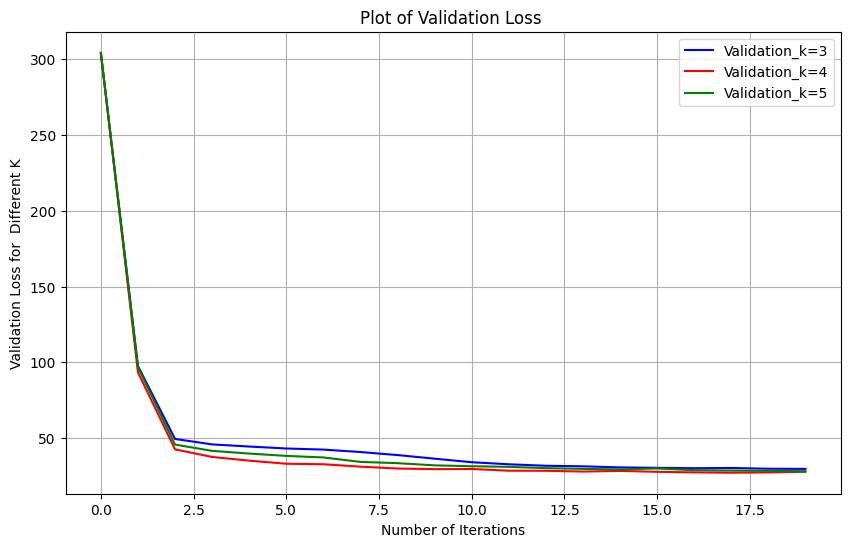

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(validation_loss_list_k3))  # Creating x-axis values


# Create the plot
plt.figure(figsize=(10, 6))  # Optional: set the figure size

# Plot both lines
plt.plot(x, validation_loss_list_k3, color='blue', label='Validation_k=3')
plt.plot(x, validation_loss_list_k4, color='red', label='Validation_k=4')
plt.plot(x, validation_loss_list, color='green', label='Validation_k=5')

# Add labels and title
plt.xlabel('Number of Iterations')
plt.ylabel('Validation Loss for  Different K')
plt.title('Plot of Validation Loss ')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)  # Optional: add a grid
plt.show()

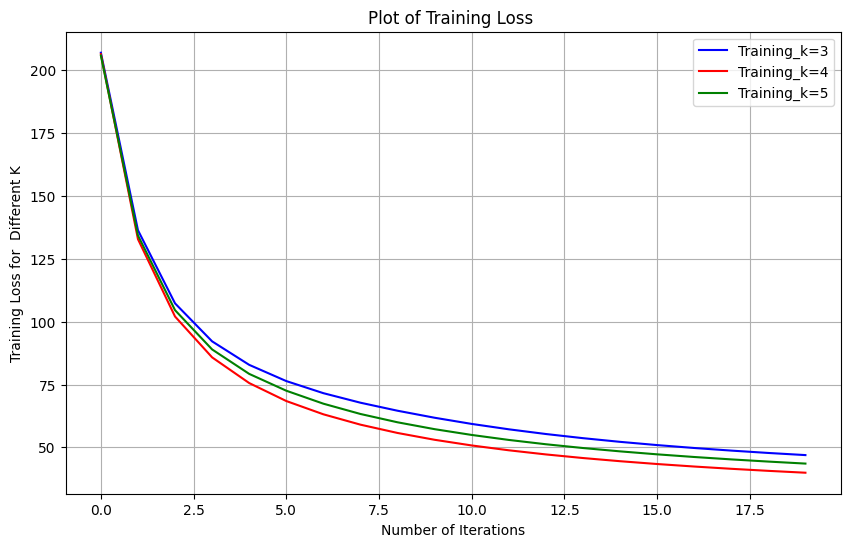

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(validation_loss_list_k3))  # Creating x-axis values


# Create the plot
plt.figure(figsize=(10, 6))  # Optional: set the figure size

# Plot both lines
plt.plot(x, final_train_loss_k3, color='blue', label='Training_k=3')
plt.plot(x, final_train_loss_k4, color='red', label='Training_k=4')
plt.plot(x, final_train_loss, color='green', label='Training_k=5')

# Add labels and title
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss for  Different K')
plt.title('Plot of Training Loss ')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)  # Optional: add a grid
plt.show()

##### Functions defined to Normalize the Inputs

#### Prediction Function

#### Driver Function For Calling the Prediction Method

#####Prediction from model having K = 3 Neighbors

In [ ]:
predict_main(best_epoch_k3,test_loader, test_target_tensor,'unmask', _mean, _std, 'test' )

load weight from: /content/drive/MyDrive/COMP9491_ASTGCN_Model/Dataset_PEMS07/Best_Epoch_Saved_Recent/k3_epoch_19.params
predicting data set batch 1 / 89
input: (5641, 883, 1, 12)
prediction: (5641, 883, 12)
data_target_tensor: (5641, 883, 12)
current epoch: 19, predict 0 points
MAE: 20.07
RMSE: 30.87
MAPE: 0.09
current epoch: 19, predict 1 points
MAE: 22.36
RMSE: 34.29
MAPE: 0.10
current epoch: 19, predict 2 points
MAE: 24.27
RMSE: 36.99
MAPE: 0.11
current epoch: 19, predict 3 points
MAE: 25.89
RMSE: 39.31
MAPE: 0.12
current epoch: 19, predict 4 points
MAE: 27.39
RMSE: 41.47
MAPE: 0.13
current epoch: 19, predict 5 points
MAE: 28.94
RMSE: 43.66
MAPE: 0.13
current epoch: 19, predict 6 points
MAE: 30.61
RMSE: 45.91
MAPE: 0.14
current epoch: 19, predict 7 points
MAE: 32.25
RMSE: 48.10
MAPE: 0.15
current epoch: 19, predict 8 points
MAE: 33.88
RMSE: 50.24
MAPE: 0.16
current epoch: 19, predict 9 points
MAE: 35.53
RMSE: 52.46
MAPE: 0.17
current epoch: 19, predict 10 points
MAE: 37.36
RMSE: 55

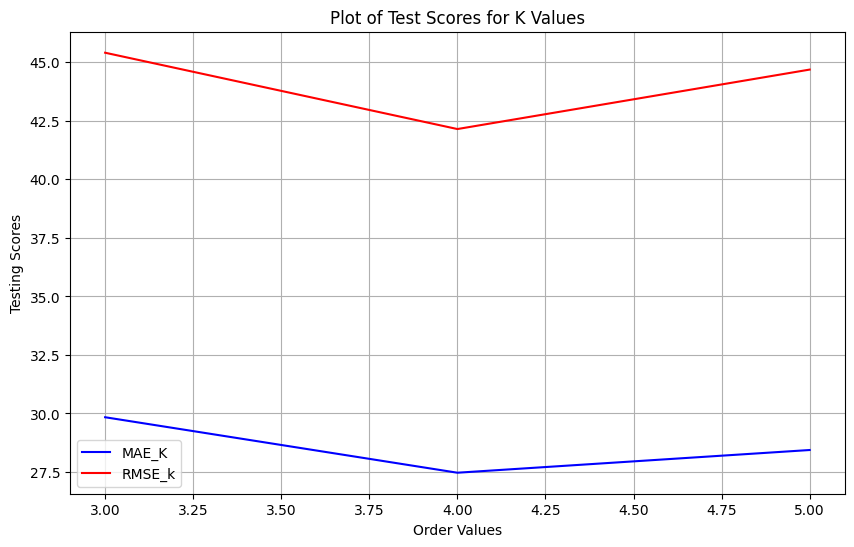

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


#x = np.arange(len(validation_loss_list_k3))  # Creating x-axis values
k_order = [3, 4, 5]


# Create the plot
plt.figure(figsize=(10, 6))  # Optional: set the figure size

MAE_values_test = [29.84, 27.47, 28.44]
RMSE_values_test = [45.41, 42.15, 44.69]

# Plot both lines
plt.plot(k_order, MAE_values_test, color='blue', label='MAE_K')
plt.plot(k_order, RMSE_values_test, color='red', label='RMSE_k')

# Add labels and title
plt.xlabel('Order Values')
plt.ylabel('Testing Scores')
plt.title('Plot of Test Scores for K Values')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)  # Optional: add a grid
plt.show()

In [ ]:
import numpy as np

##### Prediction from the Hourly Model

In [ ]:
prediction_output_recent_data = np.load('/content/drive/MyDrive/COMP9491_ASTGCN_Model/Dataset_PEMS07/Best_Epoch_Saved_Recent/output_epoch_19_test.npz')

In [ ]:
input_data = prediction_output_recent_data['input']
prediction = prediction_output_recent_data['prediction']
data_target_tensor = prediction_output_recent_data['data_target_tensor']

In [ ]:
# Print the shapes of the arrays
print("Input shape:", input_data.shape)
print("Prediction shape:", prediction.shape)
print("Target tensor shape:", data_target_tensor.shape)

# Print the first few entries of each array to inspect the data
print("Input data (first 2 samples):", input_data[0][0:2])
print("Prediction (first 2 samples):", prediction[0][0:2])
print("Data target tensor (first 2 samples):", data_target_tensor[0][0:2])
